<a href="https://colab.research.google.com/github/decao88/Machine-Learning-Sirio-Libanes/blob/main/S%C3%ADrio_Libanes_alura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação de bibliotecas
No primeiro momento de limpeza de dados, as bibliotecas utilizadas serão o Pandas e o Numpy.

In [1]:
import pandas as pd
import numpy as np

#Importação dos dados
Os dados foram retirados o Kaggle do [Sírio Libanes](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19). Eu baixei o banco e coloquei no repositório do Github deste projeto, a fim de tornar o notebook sempre reproduzível a qualquer um que o acesse.

In [2]:
dados = pd.read_excel('https://github.com/decao88/Machine-Learning-Sirio-Libanes/blob/main/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
dados.head(20)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

#Limpeza dados

## Preenchendo os valores NaN
Para que não ocorra nenhuma instância com valores NaN, vamos preencher os dados faltantes com aqueles que estão já preenchidos.

In [3]:
 features_continuas = dados.iloc[:, 13:-2].columns
 features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[features_continuas].fillna(method='ffill').fillna(method='bfill')
 features_categoricas = dados.iloc[:, :13]
 saida = dados.iloc[:, -2:]
 dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis=1)
 dados_finais.columns = dados.columns
 dados = dados_finais

## Retirada dos pacientes que foram para UTI na primeira janela de tempo
Como a ideia do modelo é verificar se o paciente que está internado vai necessitar de uma vaga em UTI, pacientes que já entram na UTI na primeira janela de tempo não serão utilizados para o treinamento.

In [4]:
#filtrando os que entraram em ICU nas primeiras horas, Vendo quais patient id tiveram essa condição e tirando fora

filtro_icu_direto = (dados['ICU'] == 1)&(dados['WINDOW'] == '0-2')
pacientes_entraram_icu_direto = dados[filtro_icu_direto]['PATIENT_VISIT_IDENTIFIER'].values
dados_pacientes_limpo = dados[~dados['PATIENT_VISIT_IDENTIFIER'].isin(pacientes_entraram_icu_direto)]

## Dados com uma linha por paciente
A estrutura deste banco de dados é um pouco não convencional. Normalmente esperaríamos que cada linha fosse um paciente, no entanto, são 5 linhas por paciente, uma para cada janela de tempo em horas:
* 0-2
* 2-4 
* 4-6 
* 6-12
* ABOVE 12 (mais de 12, em inglês)

Serão utilizados somente os dados do paciente que entra nno hospital, ou seja, os dados dos exames presentes somente a janela de tempo 0-2.

As colunas 13 até a penúltima indicam estes valores que variam dentro das janelas de tempo, então utilizaremos elas para fazer a média.

In [5]:
colunas_numericas = dados.columns[13:-2]
colunas_numericas

Index(['ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF',
       ...
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'HEART_RATE_DIFF_REL',
       'RESPIRATORY_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object', length=216)

In [6]:
def prepare_window(rows):
  if(np.any(rows['ICU'])):
    rows.loc[rows['WINDOW']=='0-2', 'ICU'] = 1
  
  return rows.loc[rows['WINDOW'] == '0-2']

dados_parametros_agrupados = dados_pacientes_limpo.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)[colunas_numericas].reset_index().drop('level_1', axis=1).set_index('PATIENT_VISIT_IDENTIFIER')
dados_parametros_agrupados

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CALCIUM_DIFF,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-1.0,...,-0.994912,-0.994912,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-1.0,...,-0.978029,-0.978029,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262
3,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,-0.972789,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.326531,0.326531,0.326531,0.326531,-1.0,...,-0.978029,-0.978029,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,-0.935113,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.35714

Existem colunas que são características da pessoa e que são imutáveis naquela janela de tempo, como a idade, gênero e doenças pré-existentes. Essas colunas serão descritas explicitamente, pois não são muitas.

In [7]:
colunas_invariáveis = ['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65',	'AGE_PERCENTIL',	'GENDER',	'DISEASE GROUPING 1',
                       'DISEASE GROUPING 2',	'DISEASE GROUPING 3',	'DISEASE GROUPING 4',
                       'DISEASE GROUPING 5',	'DISEASE GROUPING 6',	'HTN',
                       'IMMUNOCOMPROMISED',	'OTHER']

dados_caracteristicos = dados_pacientes_limpo[colunas_invariáveis].drop_duplicates(subset='PATIENT_VISIT_IDENTIFIER').set_index('PATIENT_VISIT_IDENTIFIER')
dados_caracteristicos

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,
0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
380,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
381,1,Above 90th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
382,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


É interessante verificar que a coluna *AGE_PERCENTIL* é uma string, e teremos que transformá-la em numérica através da técnica de [colunas dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), a qual vai criar uma nova coluna para cada valor único e marcará com 1 a coluna do valor que aquela linha possuía.

In [8]:
dados_age_percentil = pd.get_dummies(dados_caracteristicos['AGE_PERCENTIL'],drop_first=True)
dados_age_percentil

,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th
PATIENT_VISIT_IDENTIFIER,,,,,,,,,
0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
380,0,0,1,0,0,0,0,0,0
381,0,0,0,0,0,0,0,0,1
382,0,0,0,1,0,0,0,0,0


In [9]:
dados_caracteristicos = pd.concat([dados_caracteristicos, dados_age_percentil], axis=1).drop('AGE_PERCENTIL', axis=1)
dados_caracteristicos

,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,
0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,0
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,1,0,0,0,0,0,0
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0
5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,1,0,0,0,0,0,0
381,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,1
382,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0


Também buscamos a coluna da variávels resposta, a **ICU**. A ideia é verificar se o paciente foi ou não para a UTI, assim, foi feita uma tabela dinâmica pegando o valor máximo daquela coluna para cada paciente.

In [10]:
coluna_icu = pd.pivot_table(dados_pacientes_limpo, index='PATIENT_VISIT_IDENTIFIER', values = 'ICU', aggfunc='max')
coluna_icu

,ICU
PATIENT_VISIT_IDENTIFIER,
0,1
2,1
3,0
4,0
5,0
...,...
380,1
381,0
382,1


## Feature Selection


###Remoção de colunas com variação insignificante
Agora que os dados estão limpos e organizados, é possível remover colunas que não farão diferença na hora de contruir o modelo. 

Utilizando [Varience threshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold) nas coluna dos exames, as colunas que possuem uma variância muito baixa cairão fora. Por padrão, é setado retirar aquelas que possuem variância igual a zero.

Como o *fit_transform* não retorna o nome das colunas, achei [esse tópico](https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le) no *Stack Overflow* que mostra como pegar o nome das colunas selecionadas 

In [11]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold() #seletor
dados_parametros_agrupados_selecionados = selector.fit_transform(dados_parametros_agrupados) #dados com colunas selecionadas
cols = selector.get_support(indices=True) #buscando o nome das colunas
dados_parametros_agrupados_selecionados = dados_parametros_agrupados.iloc[:,cols] 
dados_parametros_agrupados_selecionados

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,CALCIUM_MAX,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,CREATININ_MAX,FFA_MEDIAN,FFA_MEAN,FFA_MIN,FFA_MAX,...,DIMER_MEDIAN,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,0.183673,0.183673,0.183673,0.183673,-0.868365,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-0.742004,-0.742004,...,-0.994912,-0.994912,-0.994912,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,0.357143,-0.912243,-0.912243,-0.912243,-0.912243,-0.742004,-0.742004,-0.742004,-0.742004,...,-0.978029,-0.978029,-0.978029,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262
3,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.972789,-0.972789,-0.972789,-0.972789,-1.0,-1.0,-1.0,-1.0,0.326531,0.326531,0.326531,0.326531,-0.968861,-0.968861,-0.968861,-0.968861,-0.194030,-0.194030,-0.194030,-0.194030,...,-0.978029,-0.978029,-0.978029,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.935113,-0.93

### Removendo colunas que se correlacionam

Outra maneira de selecionar colunas é verificando se a correlação entre cada coluna é alta. Em outras palavras, se duas variáveis são correlacionadas linearmente, elas possuem o mesmo efeito na variável resposta. Assim, precisamos somente de uma delas. Seguindo o tutorial de [Feature Selection envolvendo Correlação no Toward DataScience do usuário Vishal R](https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf), os códigos abaixo foram adaptados. 

***Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.*** 

Vamos criar uma visualização bastante básica da matriz de correlação, utilizando o gráfico [*Heatmap*](https://seaborn.pydata.org/generated/seaborn.heatmap.html) da biblioteca *Seaborn*

In [12]:
import seaborn as sns

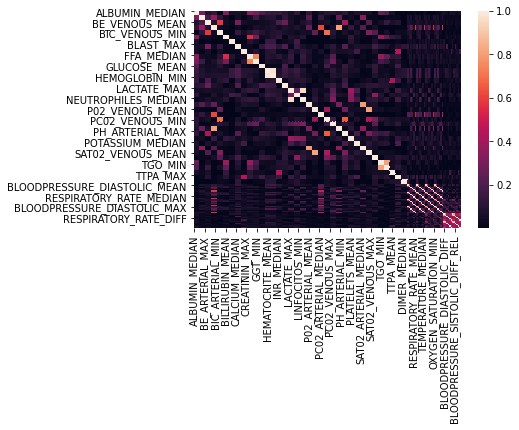

In [13]:
corr = dados_parametros_agrupados_selecionados.corr().abs() #deixando tudo com valores absolutos
sns.heatmap(corr)

In [14]:
correlacao_de_corte = 0.95

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= correlacao_de_corte:
            if columns[j]:
                columns[j] = False
selected_columns = dados_parametros_agrupados_selecionados.columns[columns]
dados_parametros_agrupados_selecionados_corr = dados_parametros_agrupados_selecionados[selected_columns]
dados_parametros_agrupados_selecionados_corr

,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,-0.932246,1.000000,-0.835844,-0.914938,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,-0.959849,1.000000,-0.382773,-0.908714,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001
3,-0.263158,-1.0,-1.000000,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.959849,-0.828421,-0.729239,-0.836100,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,-0.959849,1.000000,-0.702202,-0.641079,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805
5,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,-0.959849,1.000000,-0.706450,-0.340249,-0.170732,-0.704142,-0.77931,-0.754601,-0.997732,0.234043,0.363636,-0.292390,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.428571,-0.247863,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,-0.578947,-1.0,-1.000000,-0.317073,-0.317073,-0.293564,-1.0,0.326531,-0.937721,1.000000,-0.147196,-0.824953,-0.253669,-0.806775,1.000000,-0.704519,-0.879668,-0.170732,-0.704142,-0.77931,-0.754601,-0.565974,0.234043,0.363636,-0.895861,-0.629630,0.939394,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.357143,-0.418803,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
381,0.605263,-1.

In [15]:
valor_corte = 0.90

matrix_corr = dados_parametros_agrupados_selecionados.iloc[:,4:-2].corr().abs()
filtro= np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool)
excluir = [coluna for coluna in matrix_corr.columns if any(matrix_corr.where(filtro)[coluna]> valor_corte)]

dados_parametros_agrupados_selecionados.drop(excluir, axis = 1)

,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,-0.932246,1.000000,-0.835844,-0.914938,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,-0.959849,1.000000,-0.382773,-0.908714,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-1.000000,-0.961262
3,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.000000,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.959849,-0.828421,-0.729239,-0.836100,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,-0.959849,1.000000,-0.702202,-0.641079,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.953536,-0.980333
5,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,-0.959849,1.000000,-0.706450,-0.340249,-0.170732,-0.704142,-0.77931,-0.754601,-0.997732,0.234043,0.363636,-0.292390,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.975891,-0.980129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.000000,-0.317073,-0.317073,-0.293564,-1.0,0.326531,-0.937721,1.000000,-0.147196,-0.824953,-0.253669,-0.806775,1.000000,-0.704519,-0.879668,-0.170732,-0.704142,-0.77931,-0.754601,-0.565974,0.234043,0.363636,-0.895861,-0.629630,0.939394,0.345679,-0.428571,-0.925725,-0.981326,-0.629428,-0.860241,-0.978029,-0.160494,-0.692308

## Juntando os dataframes

Agora que a limpeza foi feita pra valer, vamos juntar de novo todos os dataframes que havíamos criado:
* dados_caracteristicos
* dados_parametros_agrupados_selecionados_corr
* coluna_icu

In [16]:
dados_limpos = pd.concat([dados_caracteristicos, dados_parametros_agrupados_selecionados_corr, coluna_icu], axis=1)
dados_limpos.dropna(inplace=True)
dados_limpos

,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th,ALBUMIN_MEDIAN,BE_ARTERIAL_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_ARTERIAL_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,-0.932246,1.000000,-0.835844,-0.914938,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,-0.959849,1.000000,-0.382773,-0.908714,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0,1,0,0,0,0,0,0,-0.263158,-1.0,-1.000000,-0.317073,-0.317073,-0.972789,-1.0,0.326531,-0.968861,-0.194030,-0.316589,-0.891993,-0.203354,-0.959849,-0.828421,-0.729239,-0.836100,-0.170732,-0.633136,-0.77931,-0.779141,-0.503592,0.234043,0.363636,-0.564753,-0.777778,0.939394,0.580247,0.200000,-0.989549,-0.956555,-0.846633,-0.937349,-0.978029,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,-0.959849,1.000000,-0.702202,-0.641079,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0
5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.000000,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,-0.959849,1.000000,-0.706450,-0.340249,-0.170732,-0.704142,-0.77931,-0.754601,-0.997732,0.234043,0.363636,-0.292390,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.428571,-0.247863,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

#Machine learning

## Modelos que podem ser implementado

Após a Feature Selection, chegou a hora de implementar os modelos de Machine Learning. Precisamos de um modelo de classificação, pois queremos apenas dizer se o paciente **VAI** ou **NÃO** para a UTI (0 ou 1) [Referência: Didática Tech - O que são problemas de Classificação e de Regressão? (Machine Learning - Aula 7)](https://www.youtube.com/watch?v=rDIocV_r9Xk).

Os principais modelos disponíveis no Scikit Learn de classificação são:
* [Suport Vector Machines](https://scikit-learn.org/stable/modules/svm.html#classification)
* [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#classification)
* [Random Forest - Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html)
* Como referência, vamos utilizar o [Dummy Classifier.](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

Definir os dados de x e y

In [17]:
x = dados_limpos.iloc[:, :-1] #todas outras colunas
y = dados_limpos.iloc[:, -1] #somente ICU

Importação das bibliotecas

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split

Definição dos modelos utilizados

In [19]:
modelo_tree = tree.DecisionTreeClassifier()
modelo_svm = svm.SVC()
modelo_random_forest = RandomForestClassifier(n_estimators=10)
modelo_dummy = DummyClassifier(strategy="most_frequent")

**Métrica de validação do modelo**

A fim diminuir a aleatoriedade do modelo, podemos utilizar o Cross Validate, que é uma maneira mais robusta de obter este resultado. Basicamente, este método divide o dataset em *k* partes, e testa ele em cada uma dessas partes, diminuindo o fator de aleatoriedade.

[*Método k-fold*](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada)

O método de validação cruzada denominado k-fold consiste em dividir o conjunto total de dados em k subconjuntos mutuamente exclusivos do mesmo tamanho e, a partir daí, um subconjunto é utilizado para teste e os k-1 restantes são utilizados para estimação dos parâmetros, fazendo-se o cálculo da acurácia do modelo. Este processo é realizado k vezes alternando de forma circular o subconjunto de teste. A figura abaixo mostra o esquema realizado pelo k-fold.



```
Exemplo do esquema de particionamento e execução do método k-fold com k = 3
Ao final das k iterações calcula-se a acurácia sobre os erros encontrados, através da equação descrita anteriormente, obtendo assim uma medida mais confiável sobre a capacidade do modelo de representar o processo gerador dos dados.
```
Ainda dentro do Cross Validate, podemos passar mais parâmetros dentro da função para que as estratégias utilizadas sejam mais adequadas ao nosso problema. Vamos utilizar o parâmetro com o cv do *Repeated Stratified KFold*, que basicamente faz o K-Fold estratificado n vezes, com diferentes aleatorizações em cada repetição. Fonte: [sklearn.model_selection.RepeatedStratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html#sklearn.model_selection.RepeatedStratifiedKFold)




Para avaliação de métricas, temos algumas alternativas:
* *Acurácia*: quantos de nossos exemplos foram de fato classificados corretamente, independente da classe. Por exemplo, se temos 100 observações e 90 delas foram classificados corretamente, nosso modelo possui uma acurácia de 90%.

* *Precisão*: Esta métrica é definida pela razão entre a quantidade de exemplos classificados corretamente como positivos e o total de exemplos classificados como positivos. A precisão dá um ênfase maior para os erros por falso positivo. Podemos entender a precisão como sendo a expressão matemática para a pergunta: dos exemplos classificados como positivos, quantos realmente são positivos?
* *Recall*: Dá maior ênfase para os erros por falso negativo. Esta métrica é definida pela razão entre a quantidade de exemplos classificados corretamente como positivos e a quantidade de exemplos que são de fato positivos.A revocação busca responder a seguinte pergunta: de todos os exemplos que são positivos, quantos foram classificados corretamente como positivos?
* *F1*: leva em consideração tanto a precisão quanto a revocação. Ela é definida pela média harmônica entre as duas.Uma das características da média harmônica é que se a precisão ou a revocação for zero ou muito próximos disso, o F1-score também será baixo. Desta forma, para que o F1-score seja alto, tanto a precisão como a revocação também devem ser altas. Ou seja, um modelo que apresenta um bom F1-score é um modelo capaz tanto de acertar suas predições (precisão alta) quanto de recuperar os exemplos da classe de interesse (revocação alta). Portanto, esta métrica tende a ser um resumo melhor da qualidade do modelo. Uma desvantagem é que a F1 acaba sendo menos interpretável que a acurácia.
* *Curva ROC*: pode ser utilizada para avaliar a performance de um classificador para diferentes limiares de classificação. Ela é construída medindo a Taxa de Falso Positivo (FPR — False Positive Rate) e a Taxa de Verdadeiro Positivo (TPR — True Positive Rate) para cada limiar de classificação possível. Ela mostra visualmente o compromisso entre falsos positivos e verdadeiro positivos na escolha do limiar. Quanto mais alto o limiar, maior é taxa de verdadeiro positivo (TP), porém a taxa de falso positivo (FP) também será maior. No caso extremo em que todos os exemplos são colocados na classe positiva, vemos que ambas as taxas chegam a 100%, enquanto no outro extremo, ambas ficam em 0%. Quanto mais próxima a curva estiver do canto superior esquerdo, melhor é a predição do modelo, dado que ele teria 100% de TPR e 0% de FPR. A linha tracejada indica qual seria curva de uma classificador que prevê classes de forma aleatória, e serve como um baseline de comparação.
A área sob a curva ROC (AUC — Area Under the Curve ou AUROC — Area Under the Receiver Operating Characteristic curve) pode ser utilizada como métrica de qualidade de um modelo, dado que quanto mais próxima a curva estiver do canto superior esquerdo, maior será a área sob a curva e melhor será o modelo. Uma vantagem desta métrica é que ela não é sensível ao desbalanço de classes, como ocorre com a acurácia. Por outro lado, a AUROC não é tão facilmente interpretável.

No caso do nosso modelo, precisamos ter uma harmonia entre a precisão e o recall, sendo assim, a métrica escolhida é o **ROC AUC**. 

Referências: https://medium.com/kunumi/m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-em-machine-learning-classifica%C3%A7%C3%A3o-49340dcdb198

Criar uma função que vai verificar as métricas para cada modelo.

Vamos precisar determinar nela:
* modelo utilizado
* dados utilizados
* em quantas vezes o Cross Validate vai dividir o nosso conjunto de dados e quantas vezes ele vai repetir o processo


In [20]:
def metrica_modelos(modelo, dados, n_splits, n_repeats):
  np.random.seed(1231)
  x = dados.iloc[:, :-1] #todas outras colunas
  y = dados.iloc[:, -1] #somente ICU

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])
  auc_std = np.std(resultados['test_score'])
  auc_std_treino = np.std(resultados['train_score'])

  #print(f'AUC {auc_medio} Intervalo [{auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}]')
  #print(f'AUC Treino {auc_medio_treino} Intervalo [{auc_medio_treino - (2*auc_std)} - {auc_medio_treino + (2*auc_std)}]')

  return auc_medio, auc_medio_treino

In [21]:
modelos = [modelo_tree, modelo_svm, modelo_random_forest, modelo_dummy]
melhor_modelo = []
for i in modelos:
    auc_medio, auc_medio_treino = metrica_modelos(i, dados_limpos, 5, 10)
    melhor_modelo.append([auc_medio, auc_medio_treino])

melhor_modelo = pd.DataFrame(melhor_modelo, columns = ['auc_medio', 'auc_treino'])
melhor_modelo['modelo'] = ['Decision Tree', 'SVM', 'Random Forest', 'Dummy']
melhor_modelo.sort_values('auc_medio', ascending=False)


,auc_medio,auc_treino,modelo
1,0.771805,0.840081,SVM
2,0.751082,0.999277,Random Forest
0,0.603722,1.000000,Decision Tree
3,0.500000,0.500000,Dummy


Analisando os modelos de maneira mais crua e levemente superficial, é possível eleger como melhor modelo o **Suport Vector Machine**! Além de possuir o maior ROC AUC, o seu AUC de treino não demonstra muito *overfit*.



##Hiperparâmetros

Após a escolha do modelo, é necessário *tunar* o mesmo, ajustando os seus hipereparâmetros. No caso no modelo SVM, vamos alterar os seguintes:
* **Kernel** - especifica qual o tipo de função utilizada no algoritmo. Deve ser *linear*, *poly*, *rbf* ou *sigmoid*. Por padrão, utiliza a *rbf*.
* **C** - parâmetro de regularização. A força da regularização é inversamente proporcional a C. Deve ser positivo.
* **gamma** - coeficiente para *rbf*, *poly* e *sigmoid*.

Referências: https://scikit-learn.org/stable/modules/svm.html, 
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC, https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

A maneira que foi utilizada para verificar rapidamente os hiperparâmetros foi criando uma lista de cada um deles, e um loop com FOR para retornar os scores de ROC_AUC médio e de treino. Assim podemos verificar se está ocorrendo o overfit também.

In [22]:
hiperparametros = []

for i in ['linear', 'poly', 'rbf', 'sigmoid']:
    for j in [1, 10]:
      for k in [1,0.1, 0.01]:
        modelo_svm = svm.SVC(kernel=i, C=j, gamma=k)
        auc_medio, auc_medio_treino =  metrica_modelos(modelo_svm, dados_limpos, 5, 10)
        hiperparametros.append([i, j, k, auc_medio, auc_medio_treino])
        print(i, j, k)

linear 1 1
linear 1 0.1
linear 1 0.01
linear 10 1
linear 10 0.1
linear 10 0.01
poly 1 1
poly 1 0.1
poly 1 0.01
poly 10 1
poly 10 0.1
poly 10 0.01
rbf 1 1
rbf 1 0.1
rbf 1 0.01
rbf 10 1
rbf 10 0.1
rbf 10 0.01
sigmoid 1 1
sigmoid 1 0.1
sigmoid 1 0.01
sigmoid 10 1
sigmoid 10 0.1
sigmoid 10 0.01


Juntando todos os resultados em um DataFrame, e ordenando pela coluna de *auc_medio*, fica fácil ver o melhor resultado.

In [23]:
hiperparametros_frame = pd.DataFrame(hiperparametros, columns = ['kernel', 'C', 'gamma', 'auc_medio', 'auc_medio_treino'])
hiperparametros_frame.sort_values(by='auc_medio', ascending=False).head(5)

,kernel,C,gamma,auc_medio,auc_medio_treino
13,rbf,1,0.10,0.782567,0.888778
17,rbf,10,0.01,0.771376,0.856473
11,poly,10,0.01,0.767114,0.808030
16,rbf,10,0.10,0.766902,0.987685
0,linear,1,1.00,0.761558,0.860996


#Modelo escolhido

Para finalizar, a modelagem escolhida foi:
* Modelo: Suport Vector Machines
* Hiperparâmetros:
    * C = 1
    * gamma = 0.10
    * kernel = rbf